In [1]:
import pandas as pd
import seaborn as sns



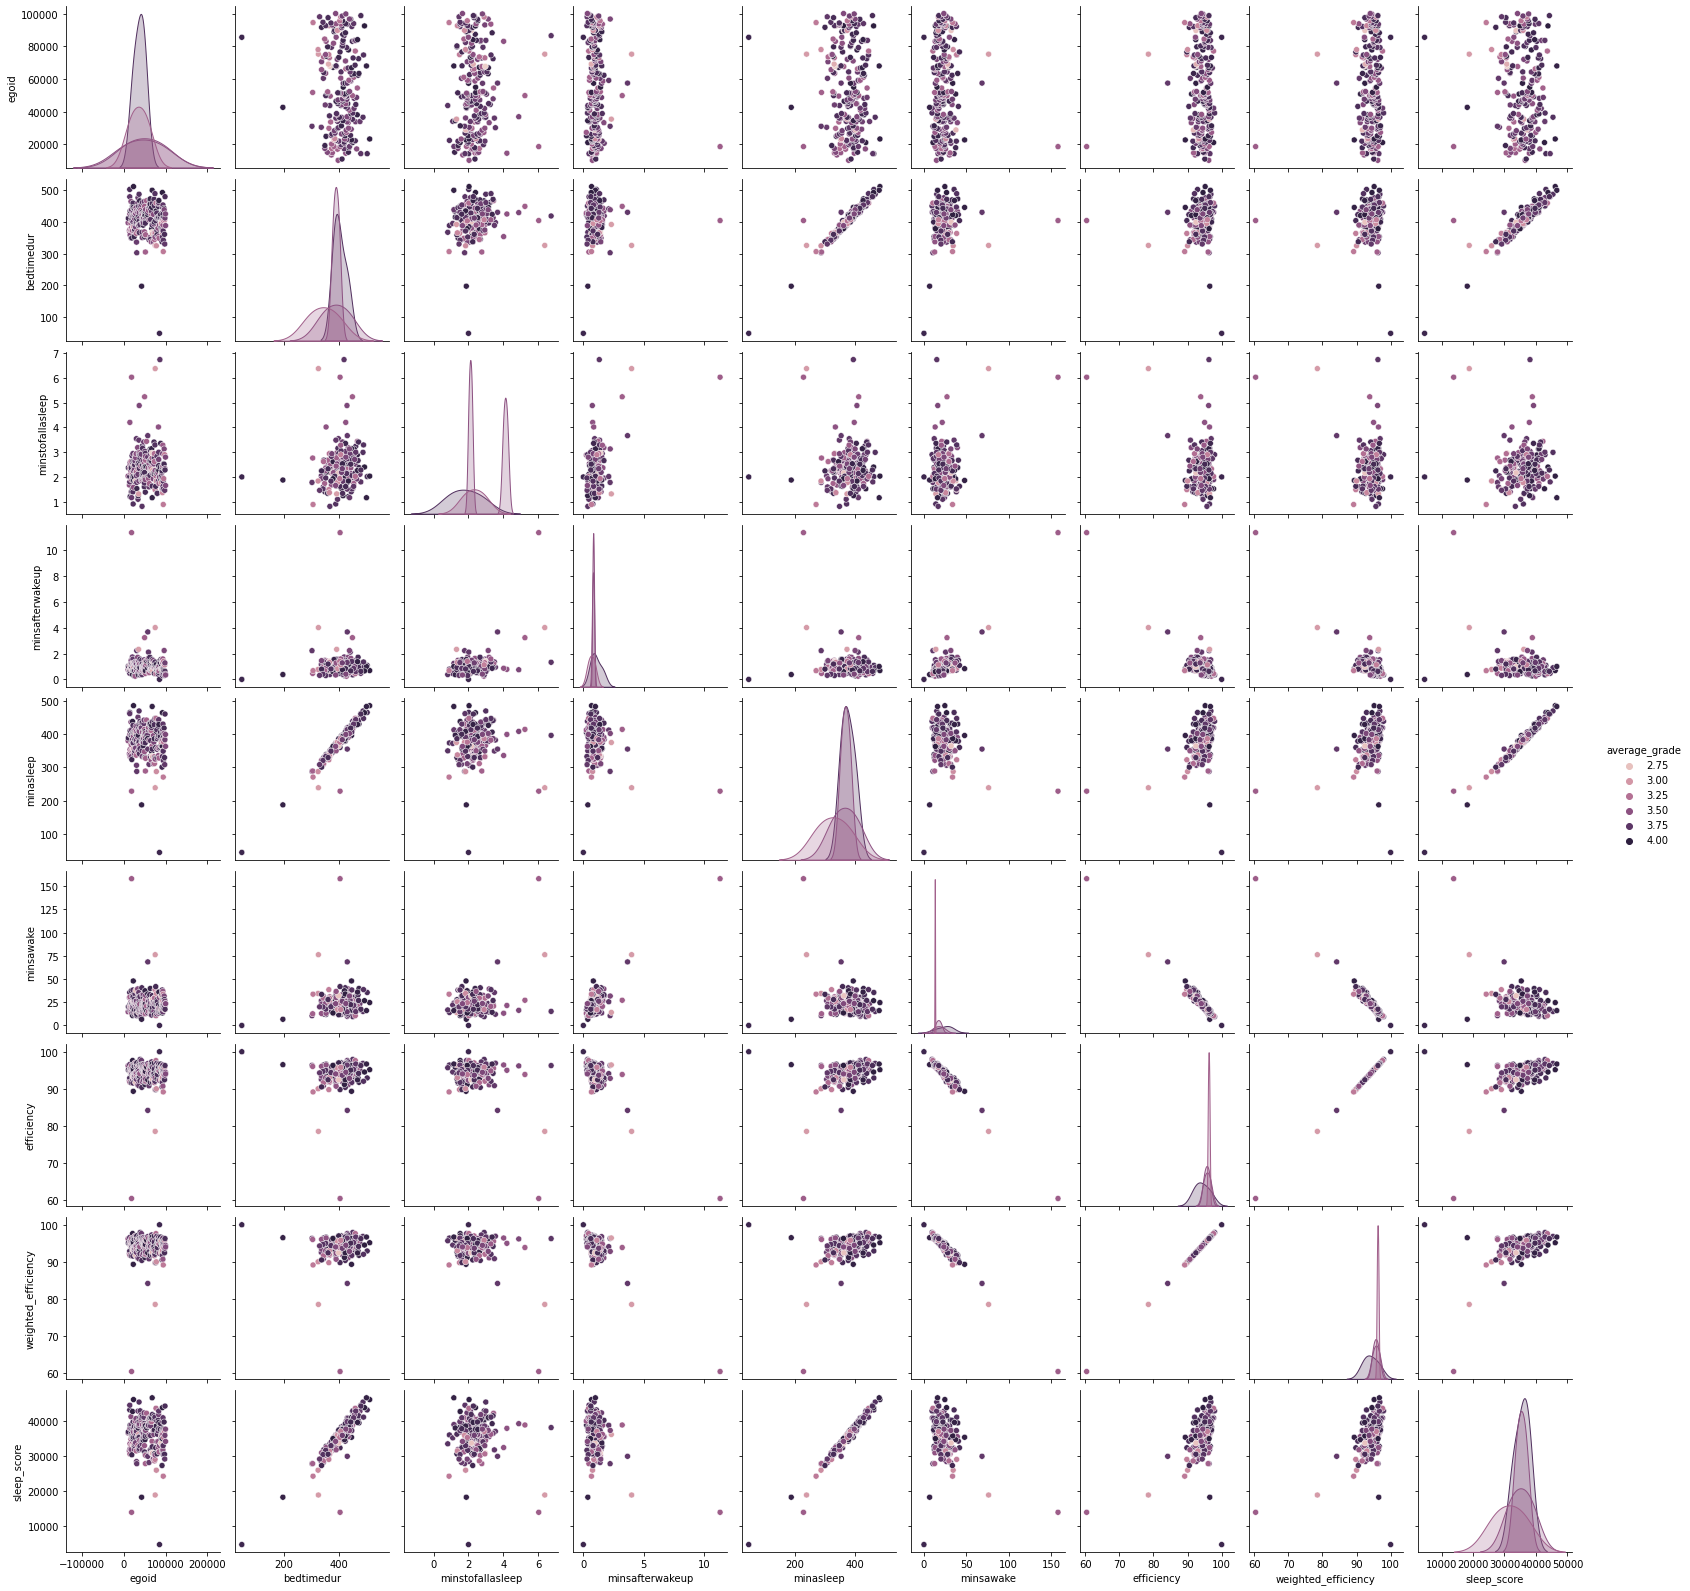

In [2]:
average_grades = pd.read_csv('average_grades.csv')
average_sleeps = pd.read_csv('average_sleeps.csv')

ans = pd.merge(average_grades, average_sleeps, on=['egoid'])

sns.pairplot(ans, hue='average_grade')